<a href="https://colab.research.google.com/github/zugzwang03/nas_unet/blob/main/NAS_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install tensorflow opencv-python

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np

def load_from_folder(folder, img_size=(64, 64), grayscale=True):
  images=[]
  for filename in sorted(os.listdir(folder))[:10]:
    path = os.path.join(folder, filename)
    img = load_img(path, target_size=img_size, color_mode='grayscale' if grayscale else 'rgb')
    img_array = img_to_array(img)
    images.append(img_array)
  return np.array(images)

In [44]:
img_folder='/content/drive/MyDrive/IrisDataset/Right Eye/Training Data/Image'
mask_folder='/content/drive/MyDrive/IrisDataset/Right Eye/Training Data/Mask'
x_train = load_from_folder(img_folder, (64, 64), True)
y_train = load_from_folder(mask_folder, (64, 64), True)
y_train = (y_train > 0).astype(np.float32)

In [45]:
img_folder='/content/drive/MyDrive/IrisDataset/Right Eye/Testing Data/Image'
mask_folder='/content/drive/MyDrive/IrisDataset/Right Eye/Testing Data/Mask'
x_test=load_from_folder(img_folder, (64, 64), True)
y_test=load_from_folder(mask_folder, (64, 64), True)
y_test = (y_test > 0).astype(np.float32)

In [46]:
img_folder='/content/drive/MyDrive/IrisDataset/Right Eye/Validation Data/Image'
mask_folder='/content/drive/MyDrive/IrisDataset/Right Eye/Validation Data/Mask'
x_val=load_from_folder(img_folder, (64, 64), True)
y_val=load_from_folder(mask_folder, (64, 64), True)
y_val = (y_val > 0).astype(np.float32)

In [47]:
np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('x_val.npy', x_val)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('y_val.npy', y_val)

In [48]:
!pip install keras-tuner

In [49]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_unet_model(hp):
    inputs = Input(shape=(64, 64, 1))  # Adjust input shape if needed

    # Encoder
    c1 = Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(hp.Int('filters4', min_value=256, max_value=512, step=256), (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(hp.Int('filters4', min_value=256, max_value=512, step=256), (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(hp.Int('filters5', min_value=512, max_value=1024, step=512), (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(hp.Int('filters5', min_value=512, max_value=1024, step=512), (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    d4 = Conv2DTranspose(hp.Int('filters4', min_value=256, max_value=512, step=256), (2, 2), strides=(2, 2), padding='same')(c5)
    d4 = concatenate([d4, c4])
    c6 = Conv2D(hp.Int('filters4', min_value=256, max_value=512, step=256), (3, 3), activation='relu', padding='same')(d4)
    c6 = Conv2D(hp.Int('filters4', min_value=256, max_value=512, step=256), (3, 3), activation='relu', padding='same')(c6)

    d3 = Conv2DTranspose(hp.Int('filters3', min_value=128, max_value=256, step=128), (2, 2), strides=(2, 2), padding='same')(c6)
    d3 = concatenate([d3, c3])
    c7 = Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu', padding='same')(d3)
    c7 = Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu', padding='same')(c7)

    d2 = Conv2DTranspose(hp.Int('filters2', min_value=64, max_value=128, step=64), (2, 2), strides=(2, 2), padding='same')(c7)
    d2 = concatenate([d2, c2])
    c8 = Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same')(d2)
    c8 = Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same')(c8)

    d1 = Conv2DTranspose(hp.Int('filters1', min_value=32, max_value=64, step=32), (2, 2), strides=(2, 2), padding='same')(c8)
    d1 = concatenate([d1, c1])
    c9 = Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same')(d1)
    c9 = Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [50]:
def build_model(hp):
    return build_unet_model(hp)

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=10,
    directory='my_dir',
    project_name='unet_nas'
)

Reloading Tuner from my_dir/unet_nas/tuner0.json


In [51]:
tuner.search(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2  # Or use a separate validation set
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7425 - loss: 9.1875 - val_accuracy: 0.2947 - val_loss: 4.1957
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2777 - loss: 4.2903 - val_accuracy: 0.7090 - val_loss: 2.0133
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 751ms/step - accuracy: 0.7476 - loss: 1.8150 - val_accuracy: 0.6914 - val_loss: 0.6072
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 0.7008 - loss: 0.6250 - val_accuracy: 0.6638 - val_loss: 0.5747
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6898 - loss: 0.5918 - val_accuracy: 0.7092 - val_loss: 0.8571
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.7461 - loss: 0.7751 - val_accuracy: 0.6958 - val_loss: 0.5430
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 557ms/step - accuracy: 0.7285 - loss: 0.5380 - val_accuracy: 0.7085 - val_loss: 0.5834
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - accuracy: 0.7453 - loss: 0.5437 - val_accuracy: 0.7056 - val_loss: 0.5170
Epoch 9/10


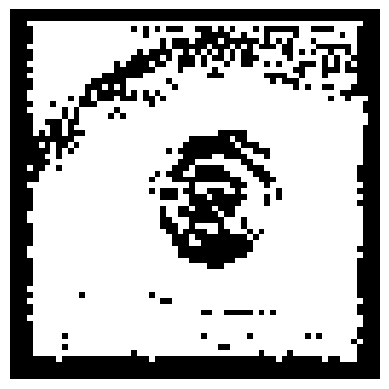

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [52]:
best_model = tuner.get_best_models(num_models=1)[0]

# Train the U-Net model
history = best_model.fit(x_train, y_train, batch_size=8, epochs=10, validation_split=0.1)

# Evaluate the best model
loss, accuracy = best_model.evaluate(x_val, y_val)  # Assuming you have a validation set
print(f"Best Model - Loss: {loss}, Accuracy: {accuracy}")

y_out = best_model.predict(x_val)
print(y_out[0])
y_out = (y_out > 0.21).astype(np.float32)
plt.imshow(y_out[0], cmap='gray')
plt.axis('off')  # To hide axis
plt.show()

print(y_out[0])
# Optionally save the best model
best_model.save('best_unet_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
[[[0.0454966 ]
  [0.00233741]
  [0.00498283]
  ...
  [0.00162036]
  [0.00045668]
  [0.02179472]]

 [[0.00177685]
  [0.010551  ]
  [0.04393356]
  ...
  [0.05722907]
  [0.02937018]
  [0.03774875]]

 [[0.0101719 ]
  [0.02808472]
  [0.18610957]
  ...
  [0.15228736]
  [0.03924279]
  [0.01380861]]

 ...

 [[0.00204997]
  [0.01114256]
  [0.01450082]
  ...
  [0.04413771]
  [0.0679374 ]
  [0.02157007]]

 [[0.00585126]
  [0.01495394]
  [0.02876042]
  ...
  [0.03650839]
  [0.07852347]
  [0.02102139]]

 [[0.00201393]
  [0.01397099]
  [0.00055439]
  ...
  [0.00105503]
  [0.01232363]
  [0.01056638]]]
0.24935064


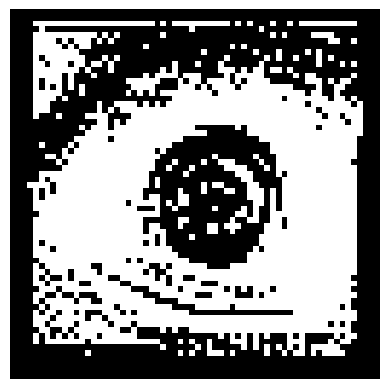

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [57]:
y_out = best_model.predict(x_val)
print(y_out[0])
print(np.mean(y_out[0]))
y_out = (y_out > 0.28).astype(np.float32)
plt.imshow(y_out[0], cmap='gray')
plt.axis('off')  # To hide axis
plt.show()

print(y_out[0])

In [54]:
# Predict masks
predictions = best_model.predict(x_test)

# Post-process predictions
# Assuming masks are binary (0 or 1), threshold the predictions
predictions = (predictions > 0.28).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


In [55]:
import matplotlib.pyplot as plt

def save_predictions(predictions, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, pred in enumerate(predictions):
        # Convert the prediction to an image
        pred_image = pred.squeeze()  # Remove single-dimensional entries
        pred_image = (pred_image * 255).astype(np.uint8)  # Scale to [0, 255] for saving as image
        output_path = os.path.join(output_folder, f'pred_{i}.png')
        plt.imsave(output_path, pred_image, cmap='gray')  # Save as grayscale image

# Define output folder for predictions
output_folder = '/content/drive/MyDrive/IrisDataset/Right Eye/Right Eye Output'  # Replace with your desired output folder path
save_predictions(predictions, output_folder)
